In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir = Path("food-101/food-101/images")

In [3]:
classes = os.listdir(os.path.join(data_dir))
print(f"Number of classes: {len(classes)}")
print(f"Sample classes: {classes[:5]}")

Number of classes: 101
Sample classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']


In [4]:
filepaths = list(data_dir.glob(r'**/*.jpg')) 
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) 

filepaths = pd.Series(filepaths, name='Filepath').astype(str) 
labels = pd.Series(labels, name='Label') 
images = pd.concat([filepaths, labels], axis=1) 

category_samples = [] 
for category in images['Label'].unique(): 
    category_slice = images.query("Label == @category") 
    category_samples.append(category_slice.sample(100, random_state=1)) 
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [5]:
image_df

,Filepath,Label
0,food-101\food-101\images\paella\1769909.jpg,paella
1,food-101\food-101\images\steak\2815172.jpg,steak
2,food-101\food-101\images\bread_pudding\272991.jpg,bread_pudding
3,food-101\food-101\images\waffles\1854304.jpg,waffles
4,food-101\food-101\images\french_toast\3009499.jpg,french_toast
...,...,...
10095,food-101\food-101\images\croque_madame\3389786...,croque_madame
10096,food-101\food-101\images\poutine\227190.jpg,poutine
10097,food-101\food-101\images\breakfast_burrito\790...,breakfast_burrito
10098,food-101\food-101\images\guacamole\2979136.jpg,guacamole


In [6]:
image_df['Label'].value_counts()

Label
paella                  100
red_velvet_cake         100
baby_back_ribs          100
shrimp_and_grits        100
cup_cakes               100
                       ... 
takoyaki                100
pad_thai                100
fried_rice              100
strawberry_shortcake    100
apple_pie               100
Name: count, Length: 101, dtype: int64

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 7070
Test set size: 3030


In [8]:
image_size = (224, 224)
batch_size = 32

In [9]:
# Image Data Generator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 15% of the training set will be used as the validation set
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed = 42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed = 42,
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


In [11]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [12]:
base_model.trainable = False

In [13]:
# Add custom layers (using functional API)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(101, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃   Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │         0 │ -                 │
│ (InputLayer)        │ 3)                │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │       864 │ input_layer[0][0] │
│                     │ 32)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │       128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │         0 │ bn_Conv1[0][0]    │
│                     │ 32)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │       288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │       128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │       512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │     1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │       384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │         0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │         0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │       864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │       384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │         0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │           │                   │
├─────────────────────┼───────────────────┼───────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │     2,304 │ block_1_depthwis… │
│ (Conv2D)            │ 24)               │     

 Total params: 2,434,981 (9.29 MB)

 Trainable params: 176,997 (691.39 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 3,
            restore_best_weights=True
        ) 
    ]
)   

Epoch 1/10


C:\Users\NISHITA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


177/177 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.0252 - loss: 4.6397 - val_accuracy: 0.1620 - val_loss: 3.7570
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.1731 - loss: 3.5639 - val_accuracy: 0.2546 - val_loss: 3.0868
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.2781 - loss: 2.8728 - val_accuracy: 0.3133 - val_loss: 2.8131
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.3307 - loss: 2.7010 - val_accuracy: 0.3303 - val_loss: 2.7002
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.3578 - loss: 2.5937 - val_accuracy: 0.3487 - val_loss: 2.6231
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.3730 - loss: 2.4919 - val_accuracy: 0.3550 - val_loss: 2.5981
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.3906 - loss: 2.3663 - val_accuracy: 0.3713 - val_loss: 2.5605
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.4172 - loss: 2.2937 - val_accuracy: 0.369

In [17]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 912ms/step - accuracy: 0.4184 - loss: 2.3008
Test Accuracy: 41.72%


In [28]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

In [29]:
# Recompile the model with a smaller learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [43]:
# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights=True
        ) 
    ]
)


Epoch 1/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.8038 - loss: 0.6780 - val_accuracy: 0.4470 - val_loss: 2.4688
Epoch 2/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.8060 - loss: 0.6533 - val_accuracy: 0.4526 - val_loss: 2.5568
Epoch 3/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 597s 3s/step - accuracy: 0.8335 - loss: 0.5665 - val_accuracy: 0.4703 - val_loss: 2.4545
Epoch 4/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 591s 3s/step - accuracy: 0.8555 - loss: 0.4931 - val_accuracy: 0.4512 - val_loss: 2.7722
Epoch 5/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 1134s 6s/step - accuracy: 0.8647 - loss: 0.4561 - val_accuracy: 0.4583 - val_loss: 2.7156
Epoch 6/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 619s 3s/step - accuracy: 0.8747 - loss: 0.4042 - val_accuracy: 0.4625 - val_loss: 2.6556
Epoch 7/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 693s 4s/step - accuracy: 0.8718 - loss: 0.4198 - val_accuracy: 0.4597 - val_loss: 2.8046
Epoch 8/30
177/177 ━━━━━━━━━━━━━━━━━━━━ 764s 4s/step - accuracy: 0.8822 - loss: 0.3876 - val_acc

In [44]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

95/95 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.5114 - loss: 2.2541
Test Accuracy: 52.05%


In [45]:
# Save the trained model
model.save('food_recognition_model.h5') 

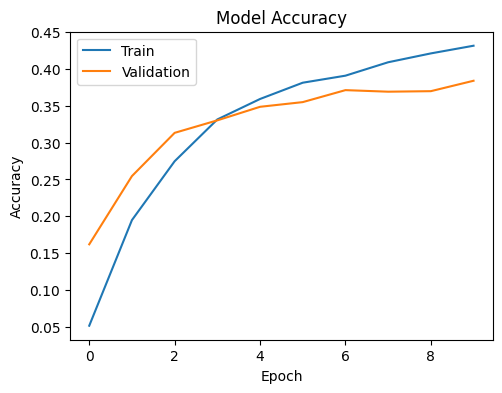

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

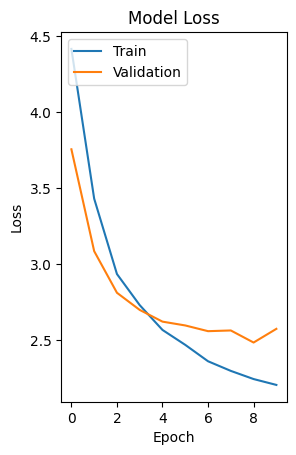

In [47]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [48]:
calorie_df = pd.read_csv("food.csv")
calorie_df.head()

,Food_name,Wt_No,Unit,Calorie
0,apple_pie,100,g,237
1,baby_back_ribs,100,g,290
2,baklava,100,g,428
3,beef_carpaccio,100,g,90
4,beef_tartare,100,g,127


In [49]:
calorie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Food_name  101 non-null    object
 1   Wt_No      101 non-null    int64 
 2   Unit       101 non-null    object
 3   Calorie    101 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ KB


In [57]:
calorie_mapping = {index: (row['Food_name'], row['Calorie']) for index, row in calorie_df.iterrows()}

In [58]:
def estimate_calories(predicted_class):
    try:
        food_item, calories = calorie_mapping[predicted_class]
        return food_item, calories
    except KeyError:
        print(f"Class index {predicted_class} not found in calorie mapping.")
        return "Unknown food item", 0


In [61]:
from tensorflow.keras.preprocessing import image

def predict_and_estimate_calories(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

     # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Estimate the calorie content
    food_item, calories = estimate_calories(predicted_class)

    plt.imshow(img)
    plt.title(f"Predicted: {food_item}, Calories: {calories} kcal")
    plt.axis('off')
    plt.show()
    return food_item, calories

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


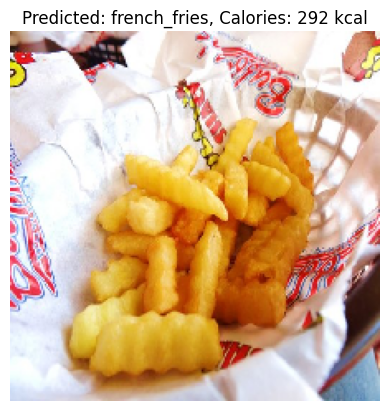

Predicted food item: french_fries
Estimated calories: 292 kcal


In [63]:
# Test the prediction (2)
img_path = 'food-101/food-101/images/french_fries/2901457.jpg'  
food_item, calories = predict_and_estimate_calories(img_path)
print(f"Predicted food item: {food_item}")
print(f"Estimated calories: {calories} kcal")